In [244]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [246]:
import metrics

In [247]:

test_preds_locs = [
    # '/home/walml/repos/gz-evo/results/baselines/regression/convnext_pico_534895718/test_predictions.csv',
    '/home/walml/repos/gz-evo/results/baselines/regression/convnext_nano_534895718/test_predictions.csv',
    '/home/walml/repos/gz-evo/results/baselines/regression/convnext_base_534895718/test_predictions.csv',
    '/home/walml/repos/gz-evo/results/baselines/regression/convnext_base.clip_laion2b_augreg_ft_in12k_534895718/test_predictions.csv',
    '/home/walml/repos/gz-evo/results/baselines/regression/maxvit_tiny_rw_224_534895718/test_predictions.csv',
    '/home/walml/repos/gz-evo/results/baselines/regression/tf_efficientnetv2_s_534895718/test_predictions.csv',
    '/home/walml/repos/gz-evo/results/baselines/regression/resnet50_534895718/test_predictions.csv'
]

In [248]:
results = []
for loc in test_preds_locs:
    results_df = metrics.regression_metrics(loc)
    results.append({
        'loc': loc,
        'model': loc.split('/')[-2],
        'mse': results_df['mse'].mean(),
        'rmse': results_df['rmse'].mean()
    })



Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [275]:
agg_df = pd.DataFrame(results)


model_names = {
    'convnext_nano_534895718': 'ConvNeXt-Nano',
    'convnext_base_534895718': 'ConvNeXt-Base',
    'convnext_base.clip_laion2b_augreg_ft_in12k_534895718': 'ConvNeXt-Base openCLIP',
    'maxvit_tiny_rw_224_534895718': 'MaxViT Tiny',
    'tf_efficientnetv2_s_534895718': 'EfficientNetV2 S'
}

agg_df['model_pretty'] = agg_df['model'].apply(lambda x: model_names[x])

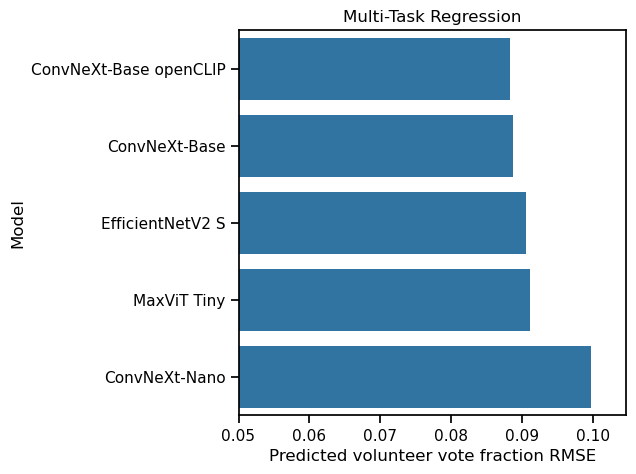

In [278]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=agg_df.sort_values('rmse'), x='rmse', y='model_pretty')
ax.set_ylabel('Model')
ax.set_xlabel('Predicted volunteer vote fraction RMSE')
ax.set_xlim(0.05, None)
ax.set_title('Multi-Task Regression')
fig.savefig('regression_overall.png', dpi=300)
fig.savefig('regression_overall.pdf', dpi=300)


In [250]:
question_answer_pairs = metrics.label_metadata.gz_evo_v1_public_pairs

In [251]:
nano_loc = '/home/walml/repos/gz-evo/results/baselines/regression/convnext_nano_534895718/test_predictions.csv'

df = metrics.load_test_preds(nano_loc)
df = metrics.blank_uncertain_votes(df, question_answer_pairs)
nano_df = metrics.get_overall_metrics(df, question_answer_pairs)
nano_df['Model'] = 'ConvNeXt Nano'

clip_loc = '/home/walml/repos/gz-evo/results/baselines/regression/convnext_base.clip_laion2b_augreg_ft_in12k_534895718/test_predictions.csv'

df = metrics.load_test_preds(clip_loc)
df = metrics.blank_uncertain_votes(df, question_answer_pairs)
clip_df = metrics.get_overall_metrics(df, question_answer_pairs)
clip_df['Model'] = 'ConvNeXt Base openCLIP'

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}{answer}_fraction_vol_masked'] = fractions
/home/walml/repos/gz-evo/baseline/metrics.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [252]:
clip_df[['question_answer', 'rmse']]

,question_answer,rmse
0,smooth-or-featured-dr12__smooth,0.095967
1,smooth-or-featured-dr12__featured-or-disk,0.087997
2,smooth-or-featured-dr12__artifact,0.065911
3,disk-edge-on-dr12__yes,0.072619
4,disk-edge-on-dr12__no,0.072619
...,...,...
189,bulge-size-hubble__dominant,0.042753
190,galaxy-symmetrical-hubble__yes,0.138703
191,galaxy-symmetrical-hubble__no,0.138703
192,clumps-embedded-larger-object-hubble__yes,0.094624


In [253]:
nano_df[['question_answer', 'rmse']]

,question_answer,rmse
0,smooth-or-featured-dr12__smooth,0.100204
1,smooth-or-featured-dr12__featured-or-disk,0.090758
2,smooth-or-featured-dr12__artifact,0.067917
3,disk-edge-on-dr12__yes,0.075996
4,disk-edge-on-dr12__no,0.075996
...,...,...
189,bulge-size-hubble__dominant,0.047368
190,galaxy-symmetrical-hubble__yes,0.154892
191,galaxy-symmetrical-hubble__no,0.154892
192,clumps-embedded-larger-object-hubble__yes,0.110105


Text(0, 0.5, '{Question}-{Telescope}__{Answer}')

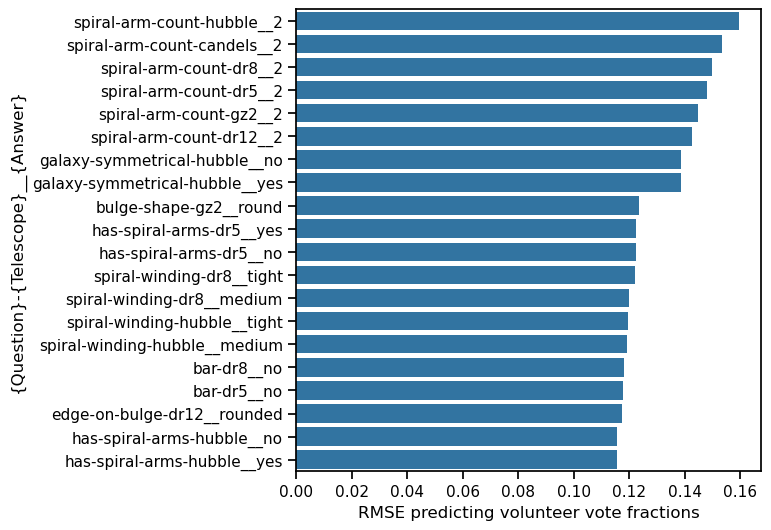

In [254]:
sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=clip_df.sort_values('rmse', ascending=False)[:20], x='rmse', y='question_answer', ax=ax)
ax.set_xlabel('RMSE predicting volunteer vote fractions')
ax.set_ylabel(r'{Question}-{Telescope}__{Answer}')

<Axes: xlabel='rmse', ylabel='question_answer'>

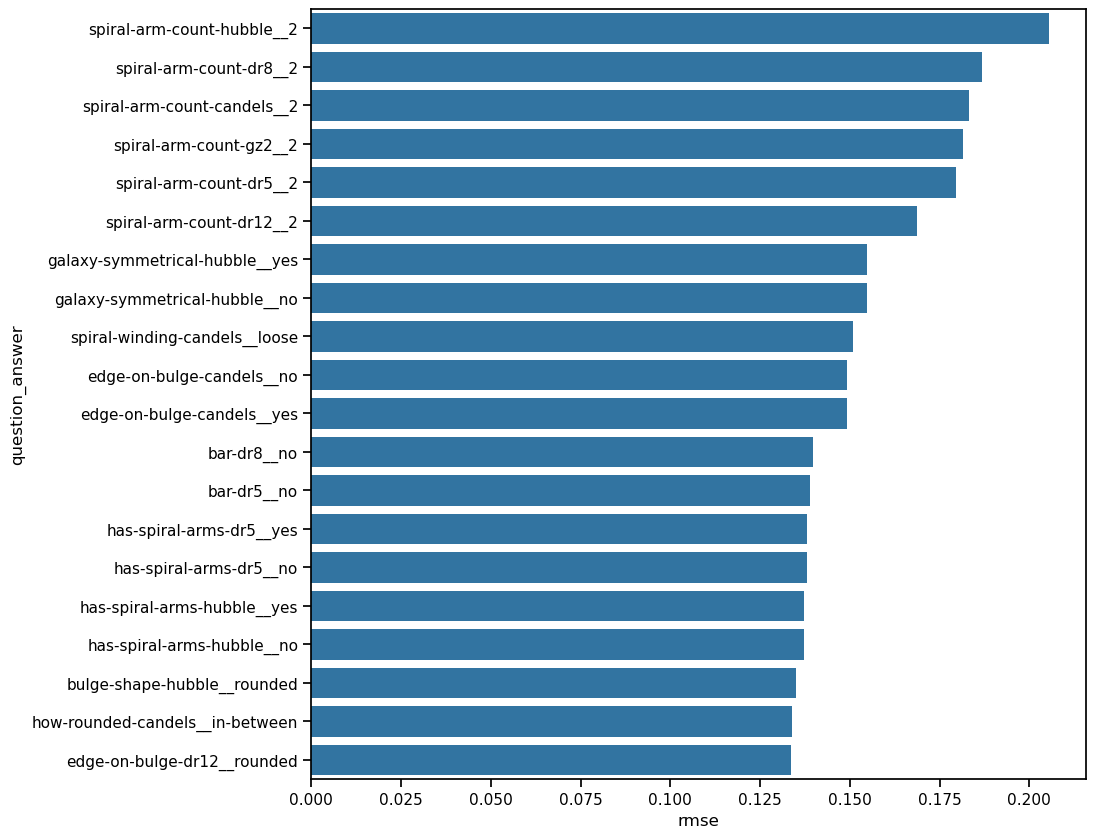

In [255]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=nano_df.sort_values('rmse', ascending=False)[:20], x='rmse', y='question_answer', ax=ax)


In [256]:
hard_questions = clip_df.sort_values('rmse', ascending=False)[:20]['question_answer'].values

In [257]:
clip_df['temp_rmse'] = clip_df['rmse']

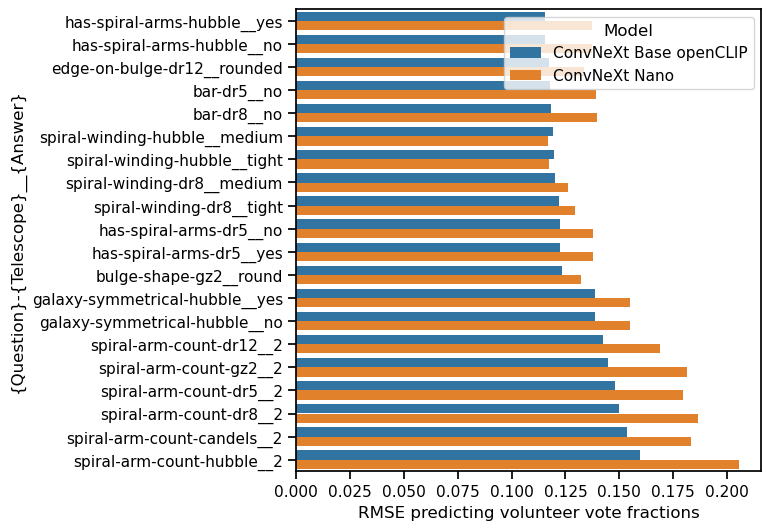

In [259]:
sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(6, 6))
both_df = pd.concat([nano_df, clip_df])
hard_df = both_df[both_df['question_answer'].isin(hard_questions)]
sns.barplot(data=hard_df.sort_values('temp_rmse'), x='rmse', y='question_answer', hue='Model', ax=ax)
ax.set_xlabel('RMSE predicting volunteer vote fractions')
ax.set_ylabel(r'{Question}-{Telescope}__{Answer}')
fig.savefig('regression_per_question.png', dpi=300)
fig.savefig('regression_per_question.pdf', dpi=300)

Text(0, 0.5, 'ML featured fraction')

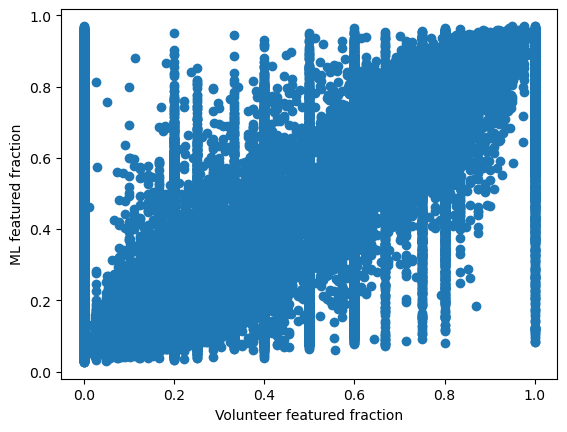

In [ ]:
# scatterplot of ml vs volunteer featured fraction
plt.scatter(df['smooth-or-featured-dr5_featured-or-disk_fraction_vol'], df['smooth-or-featured-dr5_featured-or-disk_fraction_ml'])
plt.xlabel('Volunteer featured fraction')
plt.ylabel('ML featured fraction')

Text(0, 0.5, 'ML featured fraction')

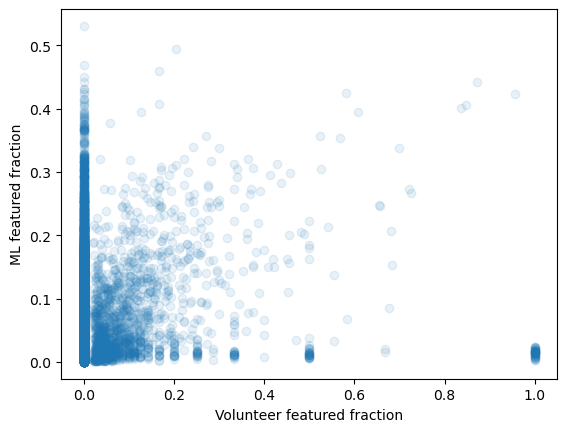

In [ ]:
# scatterplot of ml vs volunteer featured fraction
plt.scatter(df['spiral-arm-count-gz2_4_fraction_vol'], df['spiral-arm-count-gz2_4_fraction_ml'], alpha=.1)
plt.xlabel('Volunteer featured fraction')
plt.ylabel('ML featured fraction')

<Axes: >

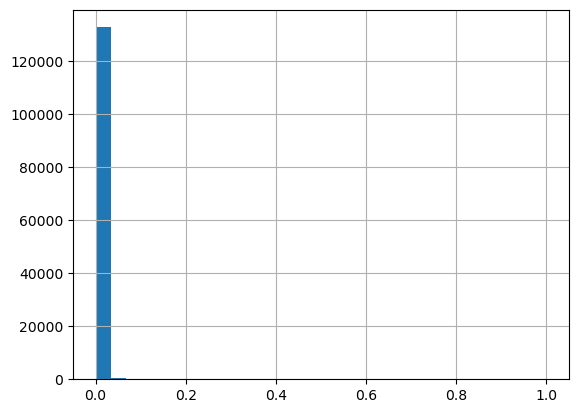

In [ ]:
df['spiral-arm-count-gz2_4_fraction_vol'].hist(bins=30)

In [ ]:
df['bar-gz2_no_fraction_vol'].isna().mean()

0.005664503386004514

In [ ]:
df['bar-gz2_yes_fraction_vol'].isna().mean()

0.005664503386004514

In [ ]:
(df['bar-gz2_total-votes'] > 20).mean()

0.026234480812641084

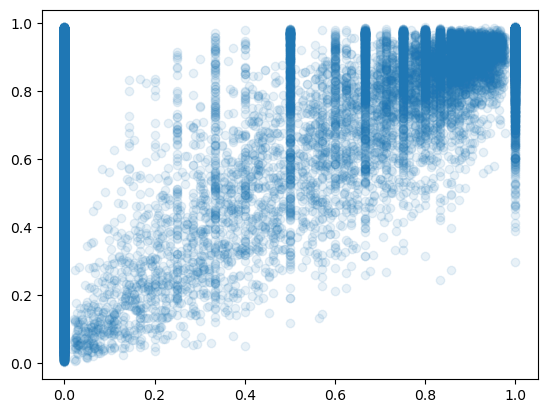

In [ ]:
# scatterplot of ml vs volunteer featured fraction
plt.scatter(df['bar-gz2_no_fraction_vol'], df['bar-gz2_no_fraction_ml'], alpha=.1)
# plt.xlabel('Volunteer featured fraction')
# plt.ylabel('ML featured fraction')

In [ ]:
question = 'bar-gz2'
answers = ['_no', '_yes']

total = df[f'{question}_total-votes']
for answer in answers:
    fractions = df[f'{question}{answer}_fraction_vol'].values
    fractions = np.where(total < 20, np.nan, fractions)

In [ ]:
np.isnan(fractions).mean()

0.9725310383747179

In [ ]:
# df[f'{question}_{answer}_fraction_vol'].isna().mean()

In [ ]:
# set fractions to nan for each answer where the question total for that answer is less than 20
from galaxy_datasets.shared import label_metadata

question_answer_pairs = label_metadata.gz_evo_v1_public_pairs

for question, answers in question_answer_pairs.items():
    total = df[f'{question}_total-votes']
    for answer in answers:
        fractions = df[f'{question}{answer}_fraction_vol'].values
        fractions = np.where(total < 20, np.nan, fractions)
        print(question, answer, np.isnan(fractions).mean())
        df[f'{question}_{answer}_fraction_vol'] = fractions

smooth-or-featured-dr12 _smooth 0.8754937923250564
smooth-or-featured-dr12 _featured-or-disk 0.8754937923250564
smooth-or-featured-dr12 _artifact 0.8754937923250564
disk-edge-on-dr12 _yes 0.971994920993228
disk-edge-on-dr12 _no 0.971994920993228
has-spiral-arms-dr12 _yes 0.981158295711061
has-spiral-arms-dr12 _no 0.981158295711061
bar-dr12 _yes 0.981158295711061
bar-dr12 _no 0.981158295711061
bulge-size-dr12 _dominant 0.981158295711061
bulge-size-dr12 _obvious 0.981158295711061
bulge-size-dr12 _none 0.981158295711061
how-rounded-dr12 _completely 0.9182773702031602
how-rounded-dr12 _in-between 0.9182773702031602
how-rounded-dr12 _cigar-shaped 0.9182773702031602
edge-on-bulge-dr12 _boxy 0.9967762415349887
edge-on-bulge-dr12 _none 0.9967762415349887
edge-on-bulge-dr12 _rounded 0.9967762415349887
spiral-winding-dr12 _tight 0.9875987584650113
spiral-winding-dr12 _medium 0.9875987584650113
spiral-winding-dr12 _loose 0.9875987584650113
spiral-arm-count-dr12 _1 0.9875987584650113
spiral-arm-co

/tmp/ipykernel_8349/3769131747.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}_{answer}_fraction_vol'] = fractions
/tmp/ipykernel_8349/3769131747.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{question}_{answer}_fraction_vol'] = fractions
/tmp/ipykernel_8349/3769131747.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [ ]:
# now calculate nan-safe MSE for each answer

from sklearn.metrics import mean_squared_error

results = []

for question, answers in question_answer_pairs.items():
    for answer in answers:
        y_true = df[f'{question}{answer}_fraction_vol']
        y_pred = df[f'{question}{answer}_fraction_ml']
        safe_mask = ~np.isnan(y_true)
        y_true = y_true[safe_mask]
        y_pred = y_pred[safe_mask]
        mse = mean_squared_error(y_true, y_pred)
        results.append({
            'question_answer': f'{question}_{answer}',
            'mse': mse,
            'nan_fraction': 1-safe_mask.mean()
        })

results_df = pd.DataFrame(results)

<Axes: xlabel='nan_fraction', ylabel='question_answer'>

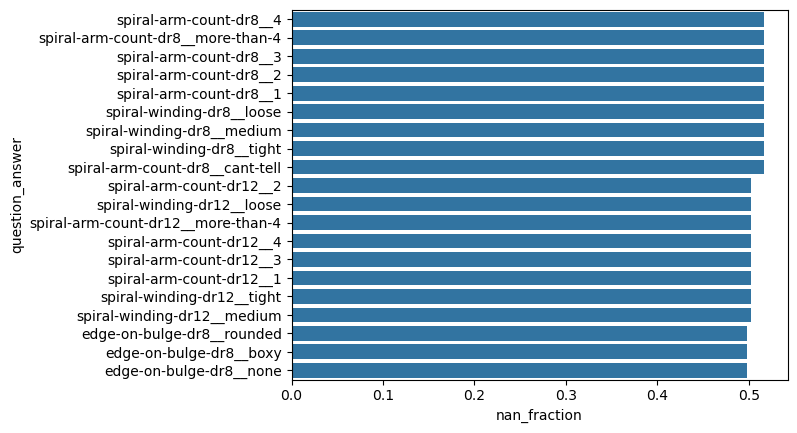

In [ ]:

sns.barplot(data=results_df.sort_values('nan_fraction', ascending=False)[:20], x='nan_fraction', y='question_answer')


<Axes: xlabel='nan_fraction', ylabel='question_answer'>

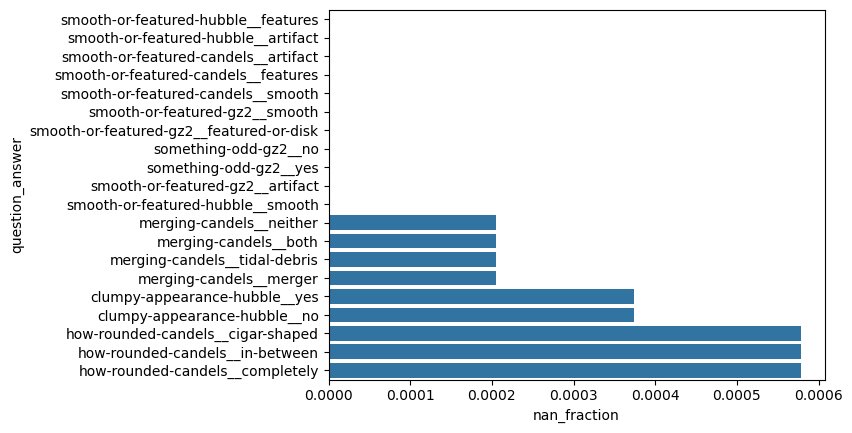

In [ ]:

sns.barplot(data=results_df.sort_values('nan_fraction', ascending=True)[:20], x='nan_fraction', y='question_answer')


<Axes: xlabel='mse', ylabel='question_answer'>

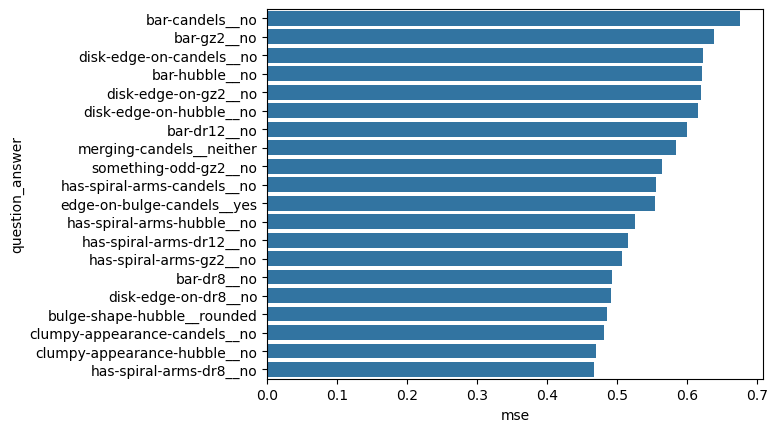

In [ ]:


sns.barplot(data=results_df.sort_values('mse', ascending=False)[:20], x='mse', y='question_answer')

# probably cut some weird questions

# then calculate the total MSE and call it a win
# final table might show total MSE and MSE for some selected questions

<Axes: xlabel='mse', ylabel='question_answer'>

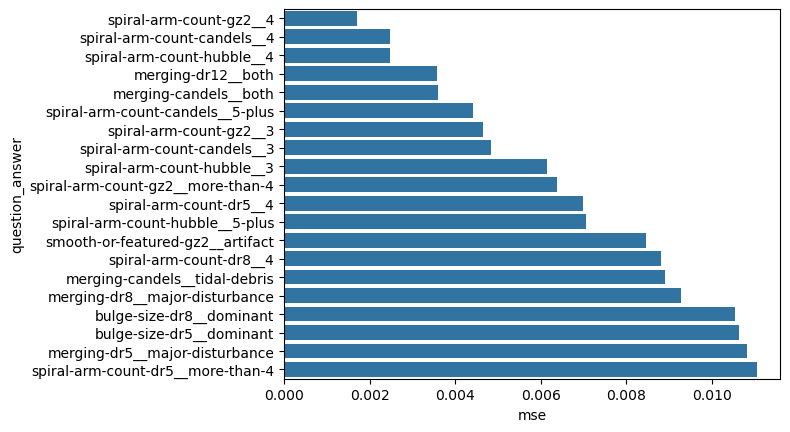

In [ ]:
sns.barplot(data=results_df.sort_values('mse', ascending=True)[:20], x='mse', y='question_answer')


In [ ]:
results_df['mse'].mean()

0.16500272439649746

In [ ]:
('convnext_base', 0.17013933001294226)
('convnext_base_laion_2b', 0.16827541777440014)
('convnext_nano', 0.16809637917158549)
('maxvit_tiny_rw_224', 0.16500272439649746)

('convnext_nano', 0.16809637917158549)